case after loop 6
case base after loop [<__main__.Case object at 0x7f6dd5b90df0>, <__main__.Case object at 0x7f6dd5b905e0>, <__main__.Case object at 0x7f6dd5b93310>, <__main__.Case object at 0x7f6dd5b92470>, <__main__.Case object at 0x7f6dd5b92bc0>]
Case base saved successfully.
case after loop 6
case base after loop [<__main__.Case object at 0x7f6dd5b90df0>, <__main__.Case object at 0x7f6dd5b905e0>, <__main__.Case object at 0x7f6dd5b93310>, <__main__.Case object at 0x7f6dd5b92470>, <__main__.Case object at 0x7f6dd5b92bc0>, <__main__.Case object at 0x7f6dd4f3f460>, <__main__.Case object at 0x7f6dd5b91360>, <__main__.Case object at 0x7f6dd5b93af0>, <__main__.Case object at 0x7f6dd5b91a50>, <__main__.Case object at 0x7f6dd5b90280>]
Case base saved successfully.


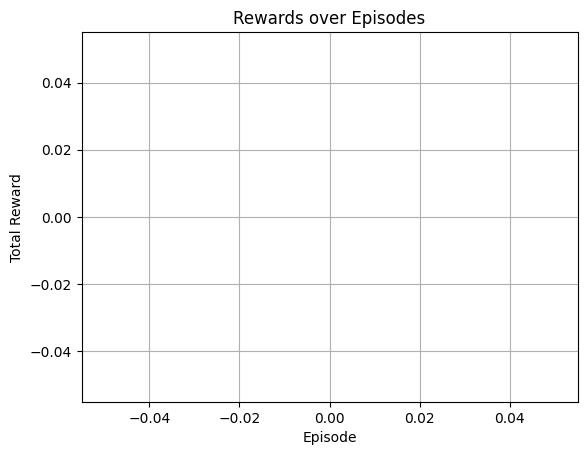

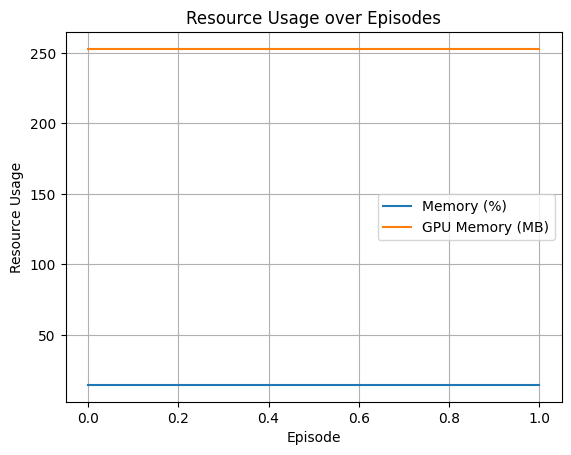

In [38]:
import numpy as np
import json
import gym
import matplotlib.pyplot as plt
import psutil
import pynvml
from collections import Counter

class ProblemSolver:
    def __init__(self, actions, epsilon=0.1, gamma=0.99, alpha=0.1, lambd=0.9):
        self.actions = actions
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.lambd = lambd
        self.Q = {}  # Q-values table
        self.e = {}  # Eligibility traces table

    def choose_action(self, state):
        if np.isscalar(state):  # Check if state is a scalar (integer or float)
            state_array = np.array([state])  # Convert scalar to numpy array
        else:
            state_array = np.asarray(state)  # Ensure state is a numpy array

        state_tuple = (state_array.item(),) if state_array.ndim == 0 else tuple(state_array.tolist())

        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            if state_tuple in self.Q:  # Use the tuple as the key
                return np.argmax(self.Q[state_tuple])
            else:
                return np.random.choice(self.actions)

    def update_Q(self, state, action, reward, next_state, next_action):
        state_array = np.asarray(state)  # Ensure state is a numpy array
        state_tuple = tuple(state_array.tolist())  # Convert numpy array to tuple

        if state_tuple not in self.Q:
            self.Q[state_tuple] = np.zeros(self.actions)
            self.e[state_tuple] = np.zeros(self.actions)

        delta = reward + self.gamma * self.Q.get(tuple(np.array(next_state).tolist()), np.zeros(self.actions))[next_action] - self.Q[state_tuple][action]
        self.e[state_tuple][action] += 1

        for s in self.Q:
            for a in range(self.actions):
                self.Q[s][a] += self.alpha * delta * self.e[s][a]
                self.e[s][a] *= self.gamma * self.lambd

class Case:
    def __init__(self, problem, solution, trust_value=1):
        self.problem = np.array(problem)  # Convert problem to numpy array
        self.solution = solution
        self.trust_value = trust_value

    @staticmethod
    def retrieve(state, case_base, threshold=0.5):
        similarities = {}
        for case in case_base:
            similarities[case] = Case.sim_q(state, case.problem)  # Compare state with the problem part of the case
        
        sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
        
        if sorted_similarities:
            most_similar_case = sorted_similarities[0][0] if sorted_similarities[0][1] >= threshold else None
        else:
            most_similar_case = None
        
        return most_similar_case

    @staticmethod
    def reuse(c, case_base, temporary_case_base):
        # Store the new case from the problem solver
        if c not in temporary_case_base:
            temporary_case_base.append(c)
        
        # Check if there are similar cases in case_base
        similar_cases = [case for case in case_base if np.array_equal(case.problem, c.problem)]
        for similar_case in similar_cases:
            if similar_case not in temporary_case_base:
                temporary_case_base.append(similar_case)

    @staticmethod
    def revise(case_base, temporary_case_base, episode_ended_successfully):
        for case in temporary_case_base:
            if episode_ended_successfully and case in case_base:
                case.trust_value += 0.1  # Increment trust value if the episode ended successfully and the case is in the case base
            elif not episode_ended_successfully and case in case_base:
                case.trust_value -= 0.1  # Decrement trust value if the episode ended unsuccessfully and the case is in the case base
            case.trust_value = max(0, min(case.trust_value,1))  # Ensure trust value is within[0,1]

    @staticmethod
    def retain(case_base, temporary_case_base, episode_ended_successfully, threshold=0):
        # print(f"temporary case base {temporary_case_base}")
        for case in temporary_case_base:
            # print(f"case {case}")
            # if episode_ended_successfully and case not in case_base:
            if case not in case_base:
                case_base.append(case)  # Insert case into case base if the episode ended successfully and it's not already in the case base

        # Remove cases with trust value < threshold
        case_base[:] = [case for case in case_base if case.trust_value >= threshold]
        print(f"case after loop {case.problem.tolist()}")
        print(f"case base after loop {case_base}")

        # Generate case_base_data
        case_base_data = [{"problem": case.problem.tolist(), "solution": case.solution, "trust_value": case.trust_value} for case in case_base]

        # Save case base after each episode
        QCBRL.save_case_base(case_base) 
        # filename = "case_base.json"
        # with open(filename, 'w') as file:
        #     json.dump(case_base_data, file)
        # print("Case base saved successfully.")

    @staticmethod
    def sim_q(state1, state2):
        state1 = np.atleast_1d(state1)  # Ensure state1 is at least 1-dimensional
        state2 = np.atleast_1d(state2)  # Ensure state2 is at least 1-dimensional
        CNDMaxDist = 6  # Maximum distance between two nodes in the CND
        v = state1.size  # Total number of objects the agent can perceive
        DistQ = np.sum([Case.Dmin_phi(Objic, Objip) for Objic, Objip in zip(state1, state2)])
        similarity = (CNDMaxDist * v - DistQ) / (CNDMaxDist * v)
        return similarity

    @staticmethod
    def Dmin_phi(X1, X2):
        return np.max(np.abs(X1 - X2))

class QCBRL:
    def __init__(self, actions, threshold=0.5, epsilon=0.1, gamma=0.99, alpha=0.1, lambd=0.9):
        self.problem_solver = ProblemSolver(actions, epsilon, gamma, alpha, lambd)
        self.case_base = []
        self.threshold = threshold
        self.temporary_case_base = []

    def train(self, episodes, max_steps, render=False):
        env = gym.make('FrozenLake-v1')
        rewards = []
        episode_rewards = []
        memory_usage = []
        gpu_memory_usage = []

        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)  # GPU Index

        for episode in range(1, episodes + 1):
            state = env.reset()
            total_reward = 0
            self.temporary_case_base = []

            for step in range(max_steps):
                if render:
                    env.render()
                action, next_state = self.take_action(state)
                next_state, reward, done, _ = env.step(action)
                next_state = np.array(next_state)
                total_reward += reward

                state = next_state
                
                if done:
                    rewards.append(total_reward)
                    episode_rewards.append(total_reward)
                    print(f"Episode {episode} ended after {step + 1} steps with total reward: {total_reward}")
                    break
                
                if done and reward == 1.0:
                    episode_ended_successfully = True
                else:
                    episode_ended_successfully = False

            Case.revise(self.case_base, self.temporary_case_base, episode_ended_successfully)
            Case.retain(self.case_base, self.temporary_case_base, episode_ended_successfully, self.threshold)

            memory_usage.append(psutil.virtual_memory().percent)
            gpu_memory_usage.append(pynvml.nvmlDeviceGetMemoryInfo(handle).used / 1024**2)

        self.save_case_base_temporary()  # Save temporary case base after training
        # self.save_case_base()  # Save case base after training

        env.close()
        self.plot_rewards(episode_rewards)
        self.plot_resources(memory_usage, gpu_memory_usage)

    def take_action(self, state):
        if np.isscalar(state):
            state_array = np.array([state])
        else:
            state_array = np.asarray(state)

        similar_solution = Case.retrieve(state_array, self.case_base)
        if similar_solution is not None:
            action = similar_solution.solution
            next_state = state
        else:
            action = self.problem_solver.choose_action(state_array)
            next_state = state_array

        if not isinstance(next_state, np.ndarray):
            next_state = np.array(next_state)

        # Add new case and similar cases to temporary_case_base
        c = Case(state, action)
        Case.reuse(c, self.case_base, self.temporary_case_base)

        return action, next_state

    def save_case_base_temporary(self):
        filename = "case_base_temporary.json"
        case_base_data = [{"problem": case.problem.tolist(), "solution": case.solution, "trust_value": case.trust_value} for case in self.temporary_case_base]
        with open(filename, 'w') as file:
            json.dump(case_base_data, file)

    def save_case_base(case_base):
        filename = "case_base.json"
        case_base_data = [{"problem": case.problem.tolist(), "solution": case.solution, "trust_value": case.trust_value} for case in case_base]
        with open(filename, 'w') as file:
            json.dump(case_base_data, file)

            print("Case base saved successfully.")  # Add this line to check if the case base is being saved
        
    def load_case_base(self):
        filename = "case_base.json"
        try:
            with open(filename, 'r') as file:
                case_base_data = json.load(file)
                self.case_base = [Case(np.array(case["problem"]), case["solution"], case["trust_value"]) for case in case_base_data]
                print("Case base loaded successfully.")  # Add this line to check if the case base is being loaded
        except FileNotFoundError:
            print("Case base file not found. Starting with an empty case base.")

    def plot_rewards(self, rewards):
        plt.plot(rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Rewards over Episodes')
        plt.grid(True)
        plt.show() 

    def plot_resources(self, memory_usage, gpu_memory_usage):
        plt.plot(memory_usage, label='Memory (%)')
        plt.plot(gpu_memory_usage, label='GPU Memory (MB)')
        plt.xlabel('Episode')
        plt.ylabel('Resource Usage')
        plt.title('Resource Usage over Episodes')
        plt.legend()
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    actions = 4  # Number of actions in FrozenLake-v1
    agent = QCBRL(actions)
    agent.train(episodes=1, max_steps=1)
